In [1]:
from pylab import *
import numpy as np
import matplotlib, pylab
from dcll.npamlib import plotLIF
from dcll.pytorch_libdcll import *
from dcll.load_dvsgestures_sparse import *

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['savefig.dpi']=400.
matplotlib.rcParams['font.size']=14.0
matplotlib.rcParams['figure.figsize']=(5.0,3.5)
matplotlib.rcParams['axes.formatter.limits']=[-10,10]
matplotlib.rcParams['axes.labelsize']= 14.
matplotlib.rcParams['figure.subplot.bottom'] = .2
matplotlib.rcParams['figure.subplot.left'] = .2       

In [2]:
#directory = "Results/105__08-10-2018/"
directory = "../Paper_results/dvsgestures/"
args = np.load(directory+"args.pkl")
testepochs = np.arange(0,args['epochs'],args['testinterval'], dtype='int')
n_iter_test = 1800
iter_test = np.arange(1,n_iter_test+20,20)
Ntests = len(testepochs)
acc_test = np.load(directory+"acc_test.npy")[:Ntests]
Nlayers = acc_test.shape[-1]


N = 288

bs = [args['batchsize'] for i in range(N//args['batchsize'])] 
if (N%args['batchsize'])>0:
    bs.append(N%args['batchsize'])

weights = np.array(bs)/N
weighted_acc = np.zeros([Ntests,Nlayers],dtype='float')
for i in range(Nlayers):
    weighted_acc[:,i] = (acc_test[:,:,i]*weights).sum(axis=1)

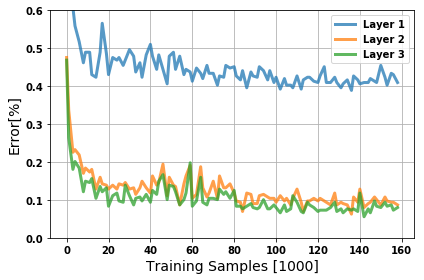

In [3]:
fig = figure()
ax = subplot(111)
for l in range(Nlayers):
    ax.plot(testepochs*args['batchsize']//1000, 1-weighted_acc[:,l], linewidth=3, alpha=.75, label = 'Layer {}'.format(l+1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,.6])
tight_layout()
savefig(directory+'convergence_dvs_gestures.png', dpi=300, frameon=False)


0.4208333333333333
0.0958333333333333
0.0819444444444444


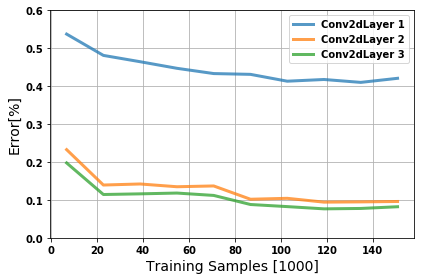

In [4]:
fig = figure(figsize=(6,4))
ax = subplot(111)
for l in range(Nlayers):
    x = testepochs*args['batchsize']//1000
    y = 1-weighted_acc[:,l]
    xm = x.reshape(-1,10).mean(axis=1)
    ym = y.reshape(-1,10).mean(axis=1)
    ax.plot(xm, ym, linewidth=3, alpha=.75, label = 'Conv2dLayer {}'.format(l+1))
    print(ym[-1])
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,.6])
tight_layout()
savefig(directory+'convergence_dvs_gestures_small.png', dpi=300, frameon=False)


In [ ]:
voutput = np.load(directory+"doutput4.npy")
soutput = np.load(directory+"doutput1.npy")
soutput = soutput.reshape(soutput.shape[0],  -1)
voutput = voutput.reshape(voutput.shape[0],  -1)
fig = figure(figsize=[10,5])
ax,_ = plotLIF(voutput[:,630:640],soutput[:,630:640],  staggering=1, color='k')
ax.set_ylabel('Neuron')
ax.set_xlabel('Time [ms]')
tight_layout()
fig.savefig(directory+'convergence_dvs_gestures_raster.png',dpi = 300)

In [ ]:
from tqdm import tqdm
def accuracy_by_vote(pvoutput, labels):
    from collections import Counter
    pvoutput_ = np.array(pvoutput).T
    n = len(pvoutput_)
    arr = np.empty(n)
    arrl = np.empty(n)
    labels_ = labels.argmax(axis=2).T
    for i in range(n):
        arr[i] = Counter(pvoutput_[i]).most_common(1)[0][0]
        arrl[i] = Counter(labels_[i]).most_common(1)[0][0]
    return float(np.mean((arr == arrl)))

labels = np.load(directory + "testlabels.npy")
inputrate = np.load(directory + "testinputrate.npy")
accs = [[] for i in range(Nlayers)]
for l in range(Nlayers):    
    clout = np.load(directory + "clout{}.npy".format(l+1))
    for i in tqdm(iter_test):
        accs[l].append(accuracy_by_vote(clout[0:i],labels))
        

In [ ]:
fig = figure()
#ax0 = subplot(211)
ax1 = subplot(111)
#ax0.plot(inputrate[1:], color='k', linewidth=3, alpha=.75)
for l in range(Nlayers):
    ax1.plot(iter_test,1-np.array(accs[l]), linewidth=3, alpha=.75, label = "Layer{}".format(l+1))
    print(1-accs[l][-1])
ax1.set_ylabel('Error[%]')
ax1.set_xlabel('Sample duration [ms]')
ax1.set_ylim([0,.3])
legend()
tight_layout()
savefig(directory+'convergence_dvs_gestures_sampleduration.png')

In [ ]:
plot_gestures_imshow()

In [ ]:
input_test = np.load(directory + "testinput.npy")

In [ ]:
def plot_gestures_imshow(images, labels, nim=11, avg=50, do1h = True, transpose=False):
    from matplotlib import colors
    import numpy as np

    np.random.seed(101)
    zvals = np.random.rand(100, 100) * 10

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['red','black', 'black','green'])
    bounds=[-1,-0.1,.1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    import pylab as plt
    plt.figure(figsize = [20,16])
    import matplotlib.gridspec as gridspec
    if not transpose:
        gs = gridspec.GridSpec(images.shape[1]//avg, nim)
    else:
        gs = gridspec.GridSpec(nim, images.shape[1]//avg)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=.0, hspace=.04)
    if do1h:
        categories = labels.argmax(axis=1)
    else:
        categories = labels
    s=[]
    for j in range(nim):
         for i in range(images.shape[1]//avg):
            if not transpose:
                 ax = plt.subplot(gs[i, j])
            else:
                 ax = plt.subplot(gs[j, i])
            on_event = images[j,i*avg:(i*avg+avg),0,:,:].sum(axis=0).T
            off_event = -images[j,i*avg:(i*avg+avg),1,:,:].sum(axis=0).T
            plt.imshow(on_event+off_event, cmap=cmap, norm=norm, interpolation='nearest')
            plt.xticks([])
            if i==0: 
                plt.title(mapping[labels[0,j].argmax()], fontsize=20)
            plt.text(3,5,'t={}ms'.format(i*avg),color='white')
            plt.yticks([])
        s.append(images[j].sum())
    print(s)

In [ ]:
plot_gestures_imshow(input_test[:100].swapaxes(0,1),labels[:5],nim=5, transpose=True, avg=10)
tight_layout()
savefig(directory+'convergence_dvs_gestures_sample.png')

In [ ]:
input_test.shape

In [ ]:
y.reshape(-1,4)